In [ ]:
!nvidia-smi

Sat Nov 19 20:14:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    44W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers datasets --quiet

     |████████████████████████████████| 5.5 MB 6.8 MB/s 
     |████████████████████████████████| 451 kB 79.8 MB/s 
     |████████████████████████████████| 7.6 MB 71.9 MB/s 
     |████████████████████████████████| 182 kB 48.4 MB/s 
     |████████████████████████████████| 212 kB 82.6 MB/s 
     |████████████████████████████████| 115 kB 84.6 MB/s 
     |████████████████████████████████| 127 kB 85.0 MB/s 


In [ ]:
#@title Imports
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt

import pandas as pd
from datasets import load_dataset, load_metric

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

import glob 

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import tensorflow as tf
from tensorflow.keras import activations, optimizers, losses
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import pickle

In [ ]:
#@title Load Data
imdb_dataset = load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
split_lengths = [len(imdb_dataset[split])for split in imdb_dataset]

print(f"Split lengths: {split_lengths}")
print(f"Features: {imdb_dataset['train'].column_names}")

Split lengths: [25000, 25000, 50000]
Features: ['text', 'label']


### EDA

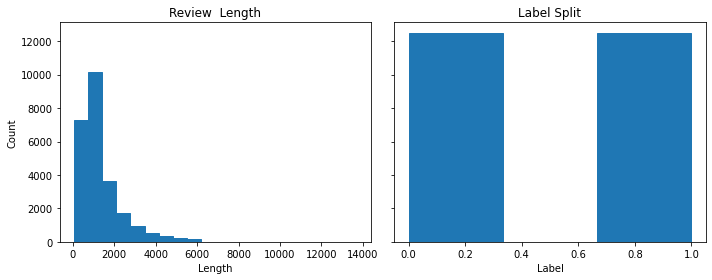

In [ ]:
#@title Review Length
review_len = [len(s) for s in imdb_dataset['train']['text']]

label_split = [s for s in imdb_dataset['train']['label']]
# review_len = [len(s) for s in dataset_amazon['train'][:10000]['review_body']]

# headline_len = [len(s) for s in dataset_amazon['train'][:10000]['review_headline']]


fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey='all' )
axes[0].hist(review_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Review  Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(label_split, bins = 3, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Label Split")
axes[1].set_xlabel("Label")
plt.tight_layout()
plt.show()

In [ ]:
count = 0
label_count = 0
for review in imdb_dataset['train']:
  if len(review['text']) > 1024:
    count +=1
    label_count += review['label']
print(count)
print(label_count)
print(label_count/count)

11749
5904
0.5025108519874032


In [ ]:
imdb_dataset['train'].shape[0]-count

13251

11,749 reviews are > 1024 words, leaving 13251 reviews with <= 1024 words. Due to the constraints on the tokenizer, we will remove any reviews > 1024 words before running the sentiment analysis. 

Next steps: determine best

In [ ]:
#@title Create DataFrame
imdb_train_df = pd.DataFrame(imdb_dataset['train'])
print(imdb_train_df.shape)
imdb_train_df.head()

(25000, 2)


,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [ ]:
import os

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls gdrive/MyDrive/amazon_summaries

finetuned_imdb_amazon_summary.csv  imdb_amazon_summary.csv


In [ ]:
#@title Create Summary DF
summary_df = pd.read_csv('gdrive/MyDrive/amazon_summaries/imdb_amazon_summary.csv')

In [ ]:
#@title Merge DF
merge_df = pd.merge(imdb_train_df, summary_df, left_index=True, right_index=True)
merge_df = merge_df.drop(['Unnamed: 0'], axis=1)
merge_df.head()

,text,label,summary
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,I AM CURIOUS-YELLOW is a good film for anyone ...
1,"""I Am Curious: Yellow"" is a risible and preten...",0,"""I Am Curious: Yellow"" is a risible and preten..."
2,If only to avoid making this type of film in t...,0,One of the worst films I've seen in a long tim...
3,This film was probably inspired by Godard's Ma...,0,"A movie of its time, and place. A movie of its..."
4,"Oh, brother...after hearing about this ridicul...",0,"Oh, brother...after hearing about this ridicul..."


In [ ]:
#@title Split to train and validation sets
train, val = train_test_split(merge_df, test_size=0.2, random_state=2022, shuffle=True)

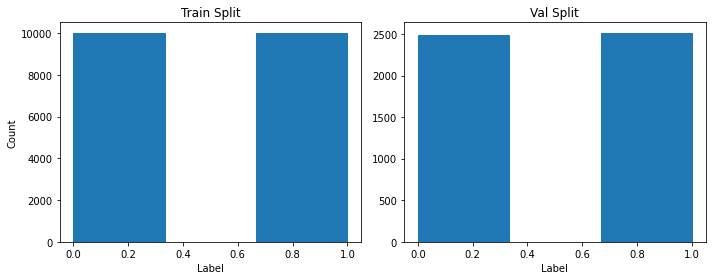

In [ ]:
#@title Review Split Labels
train_split = [s for s in train['label']]

val_split = [s for s in val['label']]
# review_len = [len(s) for s in dataset_amazon['train'][:10000]['review_body']]

# headline_len = [len(s) for s in dataset_amazon['train'][:10000]['review_headline']]


fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey='none' )
axes[0].hist(train_split, bins = 3, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Train Split")
axes[0].set_xlabel("Label")
axes[0].set_ylabel("Count")

axes[1].hist(val_split, bins = 3, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Val Split")
axes[1].set_xlabel("Label")
plt.tight_layout()
plt.show()

### DistilBert Sentiment Analysis

In [ ]:
MODEL_NAME = 'distilbert-base-uncased'


# review = x[0]

tkzr = DistilBertTokenizer.from_pretrained(MODEL_NAME)

# inputs = tkzr(review, max_length=MAX_LEN, truncation=True, padding=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
MAX_LEN = 512
def construct_encodings(x, tkzr, max_len, trucation=True, padding=True):
    return tkzr(x, max_length=max_len, truncation=trucation, padding=padding)
    
# encodings = construct_encodings(x, tkzr, max_len=MAX_LEN)



train_encodings = construct_encodings(list(train['text']), tkzr, max_len=MAX_LEN)
val_encodings = construct_encodings(list(val['text']), tkzr, max_len=MAX_LEN)

train_sum_encodings = construct_encodings(list(train['summary']), tkzr, max_len=MAX_LEN)
val_sum_encodings = construct_encodings(list(val['summary']), tkzr, max_len=MAX_LEN)

In [ ]:
def construct_tfdataset(encodings, y=None):
    if y:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))
    
tf_train = construct_tfdataset(train_encodings, list(train['label']))
tf_val = construct_tfdataset(val_encodings, list(val['label']))

tf_sum_train = construct_tfdataset(train_sum_encodings, list(train['label']))
tf_sum_val = construct_tfdataset(val_sum_encodings, list(val['label']))

In [ ]:
test_concat_tf = tf_train.concatenate(tf_sum_train)

In [ ]:
BATCH_SIZE = 16
tf_train = tf_train.batch(BATCH_SIZE)
tf_val = tf_val.batch(BATCH_SIZE)

tf_sum_train = tf_sum_train.batch(BATCH_SIZE)
tf_sum_val = tf_sum_val.batch(BATCH_SIZE)

tf_concat_train = test_concat_tf.batch(BATCH_SIZE)

In [ ]:
len(tf_train)

1250

In [ ]:
len(tf_concat_train)

2500

In [ ]:
N_EPOCHS = 5

model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME)
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

model.fit(tf_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}



Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

loading weights file tf_model.h5 from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/tf_model.h5
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at disti

Epoch 1/5
1250/1250 [==============================] - 693s 543ms/step - loss: 0.2676 - accuracy: 0.8918
Epoch 2/5
1250/1250 [==============================] - 679s 543ms/step - loss: 0.1348 - accuracy: 0.9534
Epoch 3/5
1250/1250 [==============================] - 679s 543ms/step - loss: 0.0758 - accuracy: 0.9744
Epoch 4/5
1250/1250 [==============================] - 678s 543ms/step - loss: 0.0538 - accuracy: 0.9834
Epoch 5/5
1250/1250 [==============================] - 678s 542ms/step - loss: 0.0334 - accuracy: 0.9897


In [ ]:
benchmarks = model.evaluate(tf_val, return_dict=True, batch_size=BATCH_SIZE)
print(benchmarks)

313/313 [==============================] - 60s 186ms/step - loss: 0.3387 - accuracy: 0.9050
{'loss': 0.3386838436126709, 'accuracy': 0.9049999713897705}


In [ ]:
N_EPOCHS = 5

sum_model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME)
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
sum_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

sum_model.fit(tf_sum_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}

loading weights file tf_model.h5 from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/tf_model.h5
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activ

Epoch 1/5
1250/1250 [==============================] - 689s 544ms/step - loss: 0.3409 - accuracy: 0.8478
Epoch 2/5
1250/1250 [==============================] - 679s 543ms/step - loss: 0.2278 - accuracy: 0.9085
Epoch 3/5
1250/1250 [==============================] - 680s 544ms/step - loss: 0.1459 - accuracy: 0.9469
Epoch 4/5
1250/1250 [==============================] - 679s 543ms/step - loss: 0.1019 - accuracy: 0.9661
Epoch 5/5
1250/1250 [==============================] - 679s 543ms/step - loss: 0.0796 - accuracy: 0.9735


In [ ]:
sum_benchmarks = sum_model.evaluate(tf_sum_val, return_dict=True, batch_size=BATCH_SIZE)
print(sum_benchmarks)

313/313 [==============================] - 60s 187ms/step - loss: 0.5084 - accuracy: 0.8650
{'loss': 0.508353054523468, 'accuracy': 0.8650000095367432}


In [ ]:
full_sum_benchmarks = model.evaluate(tf_sum_val, return_dict=True, batch_size=BATCH_SIZE)
print(full_sum_benchmarks)

313/313 [==============================] - 58s 186ms/step - loss: 0.6966 - accuracy: 0.8172
{'loss': 0.6966008543968201, 'accuracy': 0.8172000050544739}


In [ ]:
sum_full_benchmarks = sum_model.evaluate(tf_val, return_dict=True, batch_size=BATCH_SIZE)
print(sum_full_benchmarks)

313/313 [==============================] - 58s 186ms/step - loss: 0.4088 - accuracy: 0.8760
{'loss': 0.40881648659706116, 'accuracy': 0.8759999871253967}


In [ ]:
imdb_dataset['test']

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

In [ ]:
test = imdb_dataset['test']
test_encodings = construct_encodings(list(test['text']), tkzr, max_len=MAX_LEN)

In [ ]:
tf_test = construct_tfdataset(test_encodings, list(test['label']))
tf_test = tf_test.batch(BATCH_SIZE)

In [ ]:
test_benchmarks = model.evaluate(tf_test, return_dict=True, batch_size=BATCH_SIZE)
print(test_benchmarks)

In [ ]:
test_sum_benchmarks = sum_model.evaluate(tf_test, return_dict=True, batch_size=BATCH_SIZE)
print(test_benchmarks)

In [ ]:
#@title Concatenated Full and Summary 
N_EPOCHS = 5

concat_model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME)
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
concat_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

concat_model.fit(tf_concat_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS)

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'activation_13', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/5
2500/2500 [==============================] - 308s 118ms/step - loss: 0.2836 - accuracy: 0.8820
Epoch 2/5
2500/2500 [==============================] - 294s 118ms/step - loss: 0.1695 - accuracy: 0.9376
Epoch 3/5
2500/2500 [==============================] - 294s 118ms/step - loss: 0.0964 - accuracy: 0.9670
Epoch 4/5
2500/2500 [==============================] - 294s 118ms/step - loss: 0.0658 - accuracy: 0.9784
Epoch 5/5
2500/2500 [==============================] - 294s 118ms/step - loss: 0.0485 - accuracy: 0.9837


In [ ]:
concat_benchmarks = concat_model.evaluate(tf_val, return_dict=True, batch_size=BATCH_SIZE)
print(concat_benchmarks)

313/313 [==============================] - 13s 41ms/step - loss: 0.4831 - accuracy: 0.8900
{'loss': 0.48305147886276245, 'accuracy': 0.8899999856948853}


In [ ]:
concat_sum_benchmarks = concat_model.evaluate(tf_sum_val, return_dict=True, batch_size=BATCH_SIZE)
print(concat_sum_benchmarks)

313/313 [==============================] - 13s 41ms/step - loss: 0.5638 - accuracy: 0.8586
{'loss': 0.5637537240982056, 'accuracy': 0.8586000204086304}
